<a href="https://colab.research.google.com/github/fares-mldev/uns-ml2021/blob/main/tp6/ML_TP6_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Predicción de la clasificación de IMDB para películas

El objetivo de este proyecto es construir un modelo que prediga el puntaje de calificación de IMDB basado en atributos como duración, actores o incluso títulos. 

In [1]:
#@title Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import bz2
import pickle
import _pickle as cPickle

In [2]:
#@title Get Data

imdb_data = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectIMDB/data/movie_metadata.csv")
imdb_data.head(15)


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.0,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.0,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.0,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.0,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.0,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,Daryl Sabara,John Carter,212204,1873,Polly Walker,1.0,alien|american civil war|male nipple|mars|prin...,http://www.imdb.com/title/tt0401729/?ref_=fn_t...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,J.K. Simmons,Spider-Man 3,383056,46055,Kirsten Dunst,0.0,sandman|spider man|symbiote|venom|villain,http://www.imdb.com/title/tt0413300/?ref_=fn_t...,1902.0,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0
7,Color,Nathan Greno,324.0,100.0,15.0,284.0,Donna Murphy,799.0,200807262.0,Adventure|Animation|Comedy|Family|Fantasy|Musi...,Brad Garrett,Tangled,294810,2036,M.C. Gainey,1.0,17th century|based on fairy tale|disney|flower...,http://www.imdb.com/title/tt0398286/?ref_=fn_t...,387.0,English,USA,PG,260000000.0,2010.0,553.0,7.8,1.85,29000
8,Color,Joss Whedon,635.0,141.0,0.0,19000.0,Robert Downey Jr.,26000.0,458991599.0,Action|Adventure|Sci-Fi,Chris Hemsworth,Avengers: Age of Ultron,462669,92000,Scarlett Johansson,4.0,artificial intelligence|based on comic book|ca...,http://www.imdb.com/title/tt2395427/?ref_=fn_t...,1117.0,English,USA,PG-13,250000000.0,2015.0,21000.0,7.5,2.35,118000
9,Color,David Yates,375.0,153.0,282.0,10000.0,Daniel Radcliffe,25000.0,301956980.0,Adventure|Family|Fantasy|Mystery,Alan Rickman,Harry Potter and the Half-Blood Prince,321795,58753,Rupert Grint,3.0,blood|book|love|potion|professor,http://www.imdb.com/title/tt0417741/?ref_=fn_t...,973.0,English,UK,PG,250000000.0,2009.0,11000.0,7.5,2.35,10000


## Data preprocessing

In [3]:
#@title Data info

df = imdb_data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

In [4]:
#@title Multi-String categorical features
#@markdown Categorical values that admit multiple simultaneous activations. Ignore NaN values.

# Column names
columns_categorical_multi_str = [
                                  'genres',
                                  'plot_keywords',
                                  'actors'
                                ]

# Impute NaN values
df['genres'] = df['genres'].fillna('UNK')
df['plot_keywords'] = df['plot_keywords'].fillna('UNK')
df['actor_1_name']=df['actor_1_name'].fillna('UNK')
df['actor_2_name']=df['actor_2_name'].fillna('UNK')
df['actor_3_name']=df['actor_3_name'].fillna('UNK')

# Unify actors in single column
df['actors']=''

for idx, row in df.iterrows():

  if row['actor_1_name'] != 'UNK':
    df.loc[idx,'actors'] = row['actor_1_name']

  if row['actor_2_name'] != 'UNK':
    df.loc[idx,'actors']+= '|'
    df.loc[idx,'actors']+=row['actor_2_name'] 

  if row['actor_3_name'] != 'UNK':
    df.loc[idx,'actors']+= '|'
    df.loc[idx,'actors']+=row['actor_2_name'] 

# Init genres, plot_keywords and actors set
set_genres = set()
set_plot_keywords = set() 
set_actors = set()
                              
for idx,row in df.iterrows():

  # Populate genres set
  list_genres = str(row['genres']).split('|')
  set_genres.update(list_genres)
  
  # Populate plot_keywords set
  list_plot_keywords = str(row['plot_keywords']).split('|')
  set_plot_keywords.update(list_plot_keywords)

  # Populate actors set
  if row['actors'] != '':
    list_actors = str(row['actors']).split('|')
    set_actors.update(list_actors)

sets = {'genres': set_genres, 
        'plot_keywords': set_plot_keywords, 
        'actors': set_actors}

for s in sets:
  print(f'There are {len(sets[s])} distinct "{s}" values: ', sets[s], '... \n')


There are 26 distinct "genres" values:  {'Western', 'News', 'Action', 'Mystery', 'Family', 'History', 'Fantasy', 'Game-Show', 'Biography', 'Adventure', 'Comedy', 'Romance', 'Film-Noir', 'Sport', 'Short', 'Drama', 'Horror', 'War', 'Crime', 'Sci-Fi', 'Animation', 'Musical', 'Music', 'Reality-TV', 'Documentary', 'Thriller'} ... 

There are 8087 distinct "plot_keywords" values:  {'entity', 'magician', 'basketball team', 'bikini', 'espionage', 'identical twins', 'blade', 'british horror', 'full moon', 'dc comics', 'nuclear reactor', 'car hitting pedestrian', 'racing', 'remarriage', 'mortal kombat', 'hunter gatherer', 'belle epoque', 'sexy agent', 'exorcism', 'creature', 'd.j.', 'finger bitten off', 'pageant', 'gay pickup', 'distress signal', 'spacecraft', 'animal', 'baseball movie', 'bangkok', 'bolivia', 'herd', 'cia', 'sick child', 'remote control car', 'rogue agent', 'drug cartel', 'aura', 'samurai', 'washington heights manhattan new york city', 'dune', 'baseball team', 'houston texas', '

In [5]:
#@title String categorical features
#@markdown Categorical values that admit only one simultaneous activation. Impute NaN as category 'UKN'.

# Column names
columns_categorical_str = ['color',
                           'language',
                           'country',
                           'content_rating',
                           'director_name',
                           'aspect_ratio',
                           'title_year']

columns_categorical_all = columns_categorical_str + columns_categorical_multi_str

unique_values = {}

df[columns_categorical_str].fillna('UNK')

for column in columns_categorical_str:
  #Impute unknown values 
  df[column]=df[column].fillna('UNK') 
  
  # Get unique values
  values = list(df[column].unique())
  
  #values.sort()
  unique_values[column] = values

for column in columns_categorical_str:
  print(f'There are {len(unique_values[column])} distinct "{column}" values: ', unique_values[column][:5], '... \n')


There are 3 distinct "color" values:  ['Color', 'UNK', ' Black and White'] ... 

There are 48 distinct "language" values:  ['English', 'UNK', 'Japanese', 'French', 'Mandarin'] ... 

There are 66 distinct "country" values:  ['USA', 'UK', 'UNK', 'New Zealand', 'Canada'] ... 

There are 19 distinct "content_rating" values:  ['PG-13', 'UNK', 'PG', 'G', 'R'] ... 

There are 2399 distinct "director_name" values:  ['James Cameron', 'Gore Verbinski', 'Sam Mendes', 'Christopher Nolan', 'Doug Walker'] ... 

There are 23 distinct "aspect_ratio" values:  [1.78, 2.35, 'UNK', 1.85, 2.0] ... 

There are 92 distinct "title_year" values:  [2009.0, 2007.0, 2015.0, 2012.0, 'UNK'] ... 



In [6]:
#@title Numerical features
#@markdown Numerical values. Impute NaN as mean.

columns_numeric = [
                   'num_critic_for_reviews',
                   'num_user_for_reviews',
                   'num_voted_users',
                   'duration',
                   'movie_facebook_likes',
                   'director_facebook_likes',
                   'actor_1_facebook_likes',
                   'actor_2_facebook_likes',
                   'actor_3_facebook_likes',
                   'cast_total_facebook_likes',
                   'facenumber_in_poster',
                   'gross',
                   'budget'
                   ]

from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df[columns_numeric] = imp.fit_transform(df[columns_numeric])

print(df[columns_numeric].info())
df[columns_numeric].describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   num_critic_for_reviews     5043 non-null   float64
 1   num_user_for_reviews       5043 non-null   float64
 2   num_voted_users            5043 non-null   float64
 3   duration                   5043 non-null   float64
 4   movie_facebook_likes       5043 non-null   float64
 5   director_facebook_likes    5043 non-null   float64
 6   actor_1_facebook_likes     5043 non-null   float64
 7   actor_2_facebook_likes     5043 non-null   float64
 8   actor_3_facebook_likes     5043 non-null   float64
 9   cast_total_facebook_likes  5043 non-null   float64
 10  facenumber_in_poster       5043 non-null   float64
 11  gross                      5043 non-null   float64
 12  budget                     5043 non-null   float64
dtypes: float64(13)
memory usage: 512.3 KB
None


,num_critic_for_reviews,num_user_for_reviews,num_voted_users,duration,movie_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,gross,budget
count,5043.000000,5043.000000,5.043000e+03,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5043.000000,5.043000e+03,5.043000e+03
mean,140.194272,272.770808,8.366816e+04,107.201074,7525.964505,686.509212,6560.047061,1651.754473,645.009761,9699.063851,1.371173,4.846841e+07,3.975262e+07
std,120.997229,377.194912,1.384853e+05,25.159932,19320.445110,2784.162531,15010.328553,4037.224104,1661.239692,18163.799124,2.010978,6.216318e+07,1.958004e+08
min,1.000000,1.000000,5.000000e+00,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.620000e+02,2.180000e+02
25%,50.000000,65.000000,8.593500e+03,93.000000,0.000000,7.000000,615.500000,281.000000,134.500000,1411.000000,0.000000,8.460992e+06,7.000000e+06
50%,111.000000,157.000000,3.435900e+04,103.000000,166.000000,52.000000,989.000000,596.000000,374.000000,3090.000000,1.000000,3.743230e+07,2.300000e+07
75%,194.000000,324.000000,9.630900e+04,118.000000,3000.000000,218.000000,11000.000000,919.000000,638.000000,13756.500000,2.000000,5.135707e+07,4.000000e+07
max,813.000000,5060.000000,1.689764e+06,511.000000,349000.000000,23000.000000,640000.000000,137000.000000,23000.000000,656730.000000,43.000000,7.605058e+08,1.221550e+10


In [7]:
#@title Target { run: "auto" }

columns_target = ['imdb_score']
columns_label = ['movie_title']


In [8]:
#@title Prepare data for training / testing { run: "auto" }

# Feature column names
columns_features = columns_numeric + \
                   columns_categorical_str + \
                   columns_categorical_multi_str + \
                   columns_label

from sklearn.model_selection import train_test_split

X = df[columns_features]
y = df[columns_target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

X_train.head()

,num_critic_for_reviews,num_user_for_reviews,num_voted_users,duration,movie_facebook_likes,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,gross,budget,color,language,country,content_rating,director_name,aspect_ratio,title_year,genres,plot_keywords,actors,movie_title
2271,151.0,91.0,58957.0,117.0,0.0,20.0,11000.0,904.0,783.0,15713.0,1.0,13987482.0,20000000.0,Color,English,USA,R,Mark Mylod,1.85,2011,Comedy|Romance,ex boyfriend|morning after|prince charming|qua...,Chris Evans|Ari Graynor|Ari Graynor,What's Your Number?
3935,41.0,113.0,8535.0,99.0,872.0,60.0,979.0,665.0,444.0,3130.0,4.0,562059.0,4000000.0,Color,English,USA,R,Mars Callahan,1.85,2002,Drama|Thriller,beating|hustler|jail|money|revenge,Chazz Palminteri|Ricky Schroder|Ricky Schroder,Poolhall Junkies
2793,73.0,122.0,19805.0,93.0,0.0,85.0,1000.0,855.0,514.0,2777.0,0.0,15171475.0,8500000.0,Color,English,USA,R,Tom Holland,1.85,1996,Fantasy|Horror,death|doctor|gypsy|judge|lawyer,Joe Mantegna|Bethany Joy Lenz|Bethany Joy Lenz,Thinner
482,35.0,88.0,22955.0,114.0,0.0,31.0,9000.0,496.0,372.0,10731.0,0.0,50628009.0,90000000.0,Color,English,USA,PG,Ron Underwood,1.85,1998,Action|Adventure|Family|Fantasy|Thriller,animal|california|gorilla|hunter|poacher,Charlize Theron|Mika Boorem|Mika Boorem,Mighty Joe Young
568,176.0,138.0,59352.0,112.0,0.0,72.0,11000.0,1000.0,715.0,13827.0,0.0,70224196.0,70000000.0,Color,English,USA,PG-13,Andy Tennant,2.35,2008,Action|Adventure|Comedy|Romance|Thriller,debt|rapper|treasure|treasure hunter|yacht,Matthew McConaughey|Ray Winstone|Ray Winstone,Fool's Gold


## Define training pipeline

In [9]:
#@title Preprocessing pipeline 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog

class DummyTransformer(BaseEstimator, TransformerMixin):
    '''
    For debugging purposes
    '''

    def __init__(self, X):

      print('Dummy Constructor')
      self.X = X

    def fit(self, X, y=None):

      print('Dummy Fit')
      return self

    def transform(self, X, y=None):
      print('Dummy Transform')
      return X

class MultiHotTransformer(BaseEstimator, TransformerMixin):
    '''
    Encodes categorical data that can take more than one value at the time
    '''

    def __init__(self, X):

      self.X = X
      self.setup(X)

    def setup(self,X):
      
      self.d = dict() 
      # Iterate over columns
      for col in X:

        #Initialize set
        s = set()

        # Iterate over samples and populate transform
        for x in X[col]:
          # Populate set
         l = str(x).split('|')
         s.update(l)

        # Empty dict
        self.d[col] = dict()

        # Iterate over set and store indexes in dictionary
        for idx, val in enumerate(s):
          self.d[col][val]=idx;
  
    def fit(self, X, y=None):

      return self

    def transform(self, X, y=None):

      # Initialize return vector  
      X_ret = None
      feats = dict()

      # Iterate over columns
      for col in X:

        feats[col]=[]

        # Iterate over elements 
        for x in X[col]:
          # init feature vector
          feat = np.zeros(len(self.d[col]))
          
          # Split string
          l = str(x).split('|')

          # Iterate over items
          for item in l:
            feat[self.d[col][item]]=1

          feats[col].append(feat)
        
        if X_ret is None:
          X_ret= np.array(feats[col])
        else:
          X_ret=np.hstack((X_ret,np.array(feats[col])))
          
      return np.array(X_ret)

num = StandardScaler()
cat = MultiHotTransformer(X[columns_categorical_all])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num, columns_numeric),
        ('cat', cat, columns_categorical_all),
        ])

preprocessor.fit_transform(X_train).shape

(4034, 14906)

In [10]:
#@title Training and evaluation functions 
#@markdown As performance metric we choose Mean Average Error (MAE), since it is commonly used in rating prediction systems.

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import GridSearchCV

# Initialize dictionary for model comparison

def build_model(name,regressor):
  model=dict()
  model['pipeline']=Pipeline(steps=[('pre', preprocessor),
                                    ('pca',PCA()),
                                    (name, regressor),
                    ])
  return model

def train(model,params):

  # Metrics
  scoring = ['neg_mean_absolute_error']

  # Grid search
  gs = GridSearchCV(model['pipeline'],
                    param_grid=params,
                    scoring=scoring,
                    refit='neg_mean_absolute_error',
                    cv=3, 
                    return_train_score=True,
                    verbose=3)

  # Fit grid search
  model['trained'] = gs.fit(X_train,y_train.values.ravel())

def compare(gs):
  df_results = pd.DataFrame.from_dict(gs.cv_results_, orient='columns')
  return df_results.sort_values(by='rank_test_neg_mean_absolute_error')

def plot_residuals(model,X,y,ax,label):

  y_pred = np.array(model.predict(X)).reshape(-1,1)
  y_true = np.array(y).reshape(-1,1) 
  res = y_pred-y_true
  ax.scatter(y_true,res,label=label)

def get_row_col(idx,ncols):
  row = idx // ncols
  col = idx % ncols
  return row,col

def compare_model_residuals(models,X_train,y_train,X_test,y_test):
  N = len(models)
  ncols = 3
  nrows = N//ncols+1

  fig,axs = plt.subplots(nrows,ncols) 
  fig.set_size_inches(5*ncols,6*nrows)

  for idx,model in enumerate(models):
    
    row,col = get_row_col(idx,ncols)

    mae_train = models[model]['trained'].cv_results_['mean_train_neg_mean_absolute_error'][0]
    mae_test = models[model]['trained'].cv_results_['mean_test_neg_mean_absolute_error'][0]
    
    axs[row,col].set_title(model + '\nmae (train): ' + f'{mae_train:.2f}'+ '\nmae (test): ' + f'{mae_test:.2f}')
    plot_residuals(models[model]['trained'],X_train,y_train,axs[row,col],label='train')
    plot_residuals(models[model]['trained'],X_test,y_test,axs[row,col],label='test')

##Train models

In [11]:
#@title Init trained models

models = dict()

In [12]:
#@title Train model: Linear Regression

from sklearn.linear_model import LinearRegression

# Build model 
models['lr'] = build_model('lr', LinearRegression() )

# Model tunable parameters
params = [{
            'pca__n_components': [100],
          }]

# Train model
train(models['lr'], params)

# Compare
compare(models['lr']['trained'])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END pca__n_components=100; neg_mean_absolute_error: (train=-0.575, test=-0.626) total time=  10.8s
[CV 2/3] END pca__n_components=100; neg_mean_absolute_error: (train=-0.599, test=-0.587) total time=   8.3s
[CV 3/3] END pca__n_components=100; neg_mean_absolute_error: (train=-0.584, test=-0.611) total time=   6.7s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
0,8.252512,1.677681,0.373648,0.008857,100,{'pca__n_components': 100},-0.625652,-0.587316,-0.611329,-0.608099,0.015816,1,-0.574544,-0.598573,-0.583676,-0.585598,0.009903


In [14]:
#@title Train model: LASSO

from sklearn.linear_model import Lasso

# Build model 
models['lasso'] = build_model('lasso', Lasso() )

# Model tunable parameters
params = [{
            'pca__n_components': [100],
            'lasso__alpha': [0.00005,0.0001,0.0002],
          }]

# Train model
train(models['lasso'], params)

# Compare
compare(models['lasso']['trained'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END lasso__alpha=5e-05, pca__n_components=100; neg_mean_absolute_error: (train=-0.574, test=-0.626) total time=   6.7s
[CV 2/3] END lasso__alpha=5e-05, pca__n_components=100; neg_mean_absolute_error: (train=-0.596, test=-0.586) total time=   6.7s
[CV 3/3] END lasso__alpha=5e-05, pca__n_components=100; neg_mean_absolute_error: (train=-0.586, test=-0.615) total time=   6.7s
[CV 1/3] END lasso__alpha=0.0001, pca__n_components=100; neg_mean_absolute_error: (train=-0.574, test=-0.625) total time=   6.6s
[CV 2/3] END lasso__alpha=0.0001, pca__n_components=100; neg_mean_absolute_error: (train=-0.593, test=-0.586) total time=   6.7s
[CV 3/3] END lasso__alpha=0.0001, pca__n_components=100; neg_mean_absolute_error: (train=-0.584, test=-0.613) total time=   8.7s
[CV 1/3] END lasso__alpha=0.0002, pca__n_components=100; neg_mean_absolute_error: (train=-0.576, test=-0.625) total time=   8.2s
[CV 2/3] END lasso__alpha=0.0002, pca__n_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,param_pca__n_components,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
2,8.505278,0.464449,0.428098,0.081765,0.0002,100,"{'lasso__alpha': 0.0002, 'pca__n_components': ...",-0.624901,-0.585132,-0.612309,-0.607448,0.016595,1,-0.576189,-0.595705,-0.584022,-0.585305,0.008019
1,6.911378,0.843117,0.420475,0.090659,0.0001,100,"{'lasso__alpha': 0.0001, 'pca__n_components': ...",-0.625358,-0.585740,-0.613170,-0.608089,0.016568,2,-0.574459,-0.592629,-0.583626,-0.583571,0.007418
0,6.352002,0.002409,0.366657,0.007495,5e-05,100,"{'lasso__alpha': 5e-05, 'pca__n_components': 100}",-0.625786,-0.586023,-0.615039,-0.608949,0.016795,3,-0.573898,-0.595999,-0.586496,-0.585464,0.009052


In [15]:
#@title Train model: Ridge

from sklearn.linear_model import Ridge

# Build model 
models['ridge'] = build_model('ridge', Ridge() )

# Model tunable parameters
params = [{
            'pca__n_components': [100],
            'ridge__alpha': [0.005,0.01,0.02],
          }]

# Train model
train(models['ridge'], params)

# Compare
compare(models['ridge']['trained'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END pca__n_components=100, ridge__alpha=0.005; neg_mean_absolute_error: (train=-0.573, test=-0.624) total time=  10.1s
[CV 2/3] END pca__n_components=100, ridge__alpha=0.005; neg_mean_absolute_error: (train=-0.596, test=-0.586) total time=   6.7s
[CV 3/3] END pca__n_components=100, ridge__alpha=0.005; neg_mean_absolute_error: (train=-0.584, test=-0.614) total time=   6.7s
[CV 1/3] END pca__n_components=100, ridge__alpha=0.01; neg_mean_absolute_error: (train=-0.573, test=-0.627) total time=  10.1s
[CV 2/3] END pca__n_components=100, ridge__alpha=0.01; neg_mean_absolute_error: (train=-0.595, test=-0.586) total time=   8.8s
[CV 3/3] END pca__n_components=100, ridge__alpha=0.01; neg_mean_absolute_error: (train=-0.587, test=-0.616) total time=   6.7s
[CV 1/3] END pca__n_components=100, ridge__alpha=0.02; neg_mean_absolute_error: (train=-0.575, test=-0.628) total time=   9.6s
[CV 2/3] END pca__n_components=100, ridge__alpha=

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_ridge__alpha,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
0,7.448484,1.597126,0.379505,0.007494,100,0.005,"{'pca__n_components': 100, 'ridge__alpha': 0.005}",-0.623529,-0.585680,-0.614431,-0.60788,0.016131,1,-0.573084,-0.595929,-0.583592,-0.584202,0.009336
2,7.967426,0.949290,0.435702,0.098232,100,0.02,"{'pca__n_components': 100, 'ridge__alpha': 0.02}",-0.628215,-0.587535,-0.613230,-0.60966,0.016798,2,-0.574538,-0.596308,-0.582952,-0.584599,0.008963
1,8.153338,1.365180,0.386451,0.021024,100,0.01,"{'pca__n_components': 100, 'ridge__alpha': 0.01}",-0.626769,-0.586368,-0.615932,-0.60969,0.017074,3,-0.572999,-0.594572,-0.586650,-0.584740,0.008910


In [16]:
#@title Train model: ElasticNet

from sklearn.linear_model import ElasticNet

# Build model 
models['enet'] = build_model('enet', ElasticNet() )

# Model tunable parameters
params = [{
            'pca__n_components': [100],
            'enet__alpha': [0.0005,0.001,0.002],
            'enet__l1_ratio': [0.05,0.1,0.2],
          }]

# Train model
train(models['enet'], params)

# Compare
compare(models['enet']['trained'])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END enet__alpha=0.0005, enet__l1_ratio=0.05, pca__n_components=100; neg_mean_absolute_error: (train=-0.572, test=-0.625) total time=   8.5s
[CV 2/3] END enet__alpha=0.0005, enet__l1_ratio=0.05, pca__n_components=100; neg_mean_absolute_error: (train=-0.597, test=-0.587) total time=   6.6s
[CV 3/3] END enet__alpha=0.0005, enet__l1_ratio=0.05, pca__n_components=100; neg_mean_absolute_error: (train=-0.582, test=-0.613) total time=   8.6s
[CV 1/3] END enet__alpha=0.0005, enet__l1_ratio=0.1, pca__n_components=100; neg_mean_absolute_error: (train=-0.573, test=-0.626) total time=   6.6s
[CV 2/3] END enet__alpha=0.0005, enet__l1_ratio=0.1, pca__n_components=100; neg_mean_absolute_error: (train=-0.594, test=-0.585) total time=   8.5s
[CV 3/3] END enet__alpha=0.0005, enet__l1_ratio=0.1, pca__n_components=100; neg_mean_absolute_error: (train=-0.589, test=-0.615) total time=   7.0s
[CV 1/3] END enet__alpha=0.0005, enet__l1_ratio=0

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_enet__alpha,param_enet__l1_ratio,param_pca__n_components,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
3,6.877206,0.718463,0.365890,0.011441,0.001,0.05,100,"{'enet__alpha': 0.001, 'enet__l1_ratio': 0.05,...",-0.624200,-0.583056,-0.613818,-0.607025,0.017470,1,-0.571460,-0.594342,-0.583237,-0.583013,0.009343
6,6.279723,0.045850,0.356149,0.003625,0.002,0.05,100,"{'enet__alpha': 0.002, 'enet__l1_ratio': 0.05,...",-0.625243,-0.583212,-0.614858,-0.607771,0.017876,2,-0.573220,-0.594065,-0.585254,-0.584180,0.008544
8,6.300078,0.045105,0.361403,0.006771,0.002,0.2,100,"{'enet__alpha': 0.002, 'enet__l1_ratio': 0.2, ...",-0.626632,-0.583815,-0.613462,-0.607970,0.017906,3,-0.575398,-0.594166,-0.584107,-0.584557,0.007669
2,7.514317,0.927187,0.414436,0.064100,0.0005,0.2,100,"{'enet__alpha': 0.0005, 'enet__l1_ratio': 0.2,...",-0.623913,-0.585814,-0.614348,-0.608025,0.016184,4,-0.575003,-0.595185,-0.583716,-0.584635,0.008265
5,6.303675,0.033884,0.369364,0.014939,0.001,0.2,100,"{'enet__alpha': 0.001, 'enet__l1_ratio': 0.2, ...",-0.623723,-0.585638,-0.614983,-0.608115,0.016289,5,-0.570839,-0.595946,-0.585069,-0.583951,0.010280
0,7.532656,0.933742,0.376090,0.012946,0.0005,0.05,100,"{'enet__alpha': 0.0005, 'enet__l1_ratio': 0.05...",-0.625261,-0.586522,-0.613219,-0.608334,0.016188,6,-0.571802,-0.597163,-0.582126,-0.583697,0.010413
1,6.977428,0.786545,0.385507,0.046272,0.0005,0.1,100,"{'enet__alpha': 0.0005, 'enet__l1_ratio': 0.1,...",-0.625875,-0.584673,-0.615310,-0.608619,0.017473,7,-0.573105,-0.594218,-0.588564,-0.585296,0.008924
7,6.261230,0.065638,0.360120,0.005808,0.002,0.1,100,"{'enet__alpha': 0.002, 'enet__l1_ratio': 0.1, ...",-0.626464,-0.587214,-0.613692,-0.609123,0.016346,8,-0.577081,-0.597065,-0.585188,-0.586444,0.008207
4,6.335084,0.050969,0.444984,0.111785,0.001,0.1,100,"{'enet__alpha': 0.001, 'enet__l1_ratio': 0.1, ...",-0.627553,-0.588187,-0.615052,-0.610264,0.016424,9,-0.574293,-0.595796,-0.584702,-0.584931,0.008780


In [17]:
#@title Train model: Tweedie
from sklearn.linear_model import TweedieRegressor

# Build model 
models['twee'] = build_model('twee', TweedieRegressor() )

# Model tunable parameters
params = [{
            'pca__n_components': [200],
            'twee__power': [0,1,1.5,2,3],
            'twee__alpha': [0],
          }]

# Train model
train(models['twee'], params)

# Compare
compare(models['twee']['trained'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END pca__n_components=200, twee__alpha=0, twee__power=0; neg_mean_absolute_error: (train=-0.547, test=-0.628) total time=  13.1s
[CV 2/3] END pca__n_components=200, twee__alpha=0, twee__power=0; neg_mean_absolute_error: (train=-0.579, test=-0.583) total time=  10.6s
[CV 3/3] END pca__n_components=200, twee__alpha=0, twee__power=0; neg_mean_absolute_error: (train=-0.568, test=-0.604) total time=  10.6s
[CV 1/3] END pca__n_components=200, twee__alpha=0, twee__power=1; neg_mean_absolute_error: (train=-0.562, test=-0.643) total time=  10.3s
[CV 2/3] END pca__n_components=200, twee__alpha=0, twee__power=1; neg_mean_absolute_error: (train=-0.594, test=-0.599) total time=  10.4s
[CV 3/3] END pca__n_components=200, twee__alpha=0, twee__power=1; neg_mean_absolute_error: (train=-0.583, test=-0.623) total time=  10.4s
[CV 1/3] END pca__n_components=200, twee__alpha=0, twee__power=1.5; neg_mean_absolute_error: (train=-0.566, test

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_twee__alpha,param_twee__power,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
0,10.679896,0.914333,0.729939,0.261349,200,0,0,"{'pca__n_components': 200, 'twee__alpha': 0, '...",-0.628317,-0.582985,-0.603906,-0.605069,0.018525,1,-0.546819,-0.578986,-0.568498,-0.564768,0.013394
1,9.862713,0.039980,0.519744,0.000475,200,0,1,"{'pca__n_components': 200, 'twee__alpha': 0, '...",-0.643185,-0.598856,-0.623068,-0.621703,0.018123,2,-0.562284,-0.594318,-0.583330,-0.579978,0.013291
2,9.978769,0.148306,0.509181,0.009839,200,0,1.5,"{'pca__n_components': 200, 'twee__alpha': 0, '...",-0.644903,-0.600656,-0.620218,-0.621926,0.018104,3,-0.565797,-0.597377,-0.586333,-0.583169,0.013085
3,9.834124,0.079236,0.511607,0.003891,200,0,2,"{'pca__n_components': 200, 'twee__alpha': 0, '...",-0.652093,-0.604187,-0.624612,-0.626964,0.019628,4,-0.566358,-0.602985,-0.589092,-0.586145,0.015098
4,10.007887,0.050701,0.509516,0.007492,200,0,3,"{'pca__n_components': 200, 'twee__alpha': 0, '...",-0.659684,-0.615445,-0.630051,-0.635060,0.018404,5,-0.574949,-0.613228,-0.601924,-0.596701,0.016058


In [18]:
#@title Train model: LARS
from sklearn.linear_model import Lars

# Build model 
models['lars'] = build_model('lars', Lars() )

# Model tunable parameters
params = [{
            'pca__n_components': [100],
            'lars__eps': [0.5,0.75,1],
          }]

# Train model
train(models['lars'], params)

# Compare
compare(models['lars']['trained'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


[CV 1/3] END lars__eps=0.5, pca__n_components=100; neg_mean_absolute_error: (train=-0.573, test=-0.626) total time=   6.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


[CV 2/3] END lars__eps=0.5, pca__n_components=100; neg_mean_absolute_error: (train=-0.598, test=-0.586) total time=   6.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


[CV 3/3] END lars__eps=0.5, pca__n_components=100; neg_mean_absolute_error: (train=-0.583, test=-0.614) total time=   6.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


[CV 1/3] END lars__eps=0.75, pca__n_components=100; neg_mean_absolute_error: (train=-0.573, test=-0.624) total time=   6.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


[CV 2/3] END lars__eps=0.75, pca__n_components=100; neg_mean_absolute_error: (train=-0.595, test=-0.583) total time=   6.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


[CV 3/3] END lars__eps=0.75, pca__n_components=100; neg_mean_absolute_error: (train=-0.585, test=-0.613) total time=   6.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


[CV 1/3] END lars__eps=1, pca__n_components=100; neg_mean_absolute_error: (train=-0.572, test=-0.625) total time=   6.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


[CV 2/3] END lars__eps=1, pca__n_components=100; neg_mean_absolute_error: (train=-0.597, test=-0.586) total time=   6.9s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


[CV 3/3] END lars__eps=1, pca__n_components=100; neg_mean_absolute_error: (train=-0.583, test=-0.613) total time=   6.8s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lars__eps,param_pca__n_components,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
1,6.440312,0.017614,0.435899,0.006362,0.75,100,"{'lars__eps': 0.75, 'pca__n_components': 100}",-0.623977,-0.583157,-0.613471,-0.606868,0.017306,1,-0.572530,-0.595244,-0.584810,-0.584195,0.009283
2,6.411079,0.030758,0.437038,0.006472,1,100,"{'lars__eps': 1, 'pca__n_components': 100}",-0.625221,-0.585791,-0.613022,-0.608011,0.016483,2,-0.571802,-0.597416,-0.583053,-0.584090,0.010483
0,6.429382,0.026768,0.427095,0.005766,0.5,100,"{'lars__eps': 0.5, 'pca__n_components': 100}",-0.625892,-0.586261,-0.614124,-0.608759,0.016618,3,-0.573490,-0.597947,-0.582800,-0.584746,0.010079


In [19]:
#@title Train model: RANSAC
from sklearn.linear_model import RANSACRegressor

# Build model 
models['ransac'] = build_model('ransac', RANSACRegressor() )

# Model tunable parameters
params = [{
            'pca__n_components': [100],
            'ransac__min_samples': [10,20,50],
            #'ransac__base_estimator': [Lasso(alpha=0.01)],
          }]

# Train model
train(models['ransac'], params)

# Compare
compare(models['ransac']['trained'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END pca__n_components=100, ransac__min_samples=10; neg_mean_absolute_error: (train=-0.688, test=-0.722) total time=   7.0s
[CV 2/3] END pca__n_components=100, ransac__min_samples=10; neg_mean_absolute_error: (train=-0.713, test=-0.696) total time=   7.0s
[CV 3/3] END pca__n_components=100, ransac__min_samples=10; neg_mean_absolute_error: (train=-0.678, test=-0.737) total time=   7.0s
[CV 1/3] END pca__n_components=100, ransac__min_samples=20; neg_mean_absolute_error: (train=-0.658, test=-0.701) total time=   7.1s
[CV 2/3] END pca__n_components=100, ransac__min_samples=20; neg_mean_absolute_error: (train=-0.710, test=-0.683) total time=   7.1s
[CV 3/3] END pca__n_components=100, ransac__min_samples=20; neg_mean_absolute_error: (train=-0.651, test=-0.672) total time=   7.1s
[CV 1/3] END pca__n_components=100, ransac__min_samples=50; neg_mean_absolute_error: (train=-0.725, test=-0.774) total time=   7.1s
[CV 2/3] END pca_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_ransac__min_samples,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
1,6.656351,0.021106,0.454811,0.011942,100,20,"{'pca__n_components': 100, 'ransac__min_sample...",-0.700868,-0.683272,-0.671790,-0.685310,0.011958,1,-0.658162,-0.710283,-0.650583,-0.673009,0.026537
0,6.547618,0.025933,0.443612,0.010246,100,10,"{'pca__n_components': 100, 'ransac__min_sample...",-0.722224,-0.696107,-0.737067,-0.718466,0.016932,2,-0.688338,-0.712634,-0.677750,-0.692907,0.014603
2,6.821811,0.095027,0.444084,0.016408,100,50,"{'pca__n_components': 100, 'ransac__min_sample...",-0.773877,-0.718238,-0.838309,-0.776808,0.049062,3,-0.724509,-0.721475,-0.706338,-0.717441,0.007948


In [21]:
#@title Train model: Regression tree
from sklearn.tree import DecisionTreeRegressor

# Build model 
models['dtr'] = build_model('dtr', DecisionTreeRegressor() )

# Model tunable parameters
params = [{
            'pca__n_components': [100],
            'dtr__criterion': ['squared_error'],
            'dtr__ccp_alpha': [0.001,0.002,0.005]
          }]

# Train model
train(models['dtr'], params)

# Compare
compare(models['dtr']['trained'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END dtr__ccp_alpha=0.001, dtr__criterion=squared_error, pca__n_components=100; neg_mean_absolute_error: (train=-0.354, test=-0.882) total time=   7.6s
[CV 2/3] END dtr__ccp_alpha=0.001, dtr__criterion=squared_error, pca__n_components=100; neg_mean_absolute_error: (train=-0.357, test=-0.806) total time=   7.5s
[CV 3/3] END dtr__ccp_alpha=0.001, dtr__criterion=squared_error, pca__n_components=100; neg_mean_absolute_error: (train=-0.350, test=-0.815) total time=   7.1s
[CV 1/3] END dtr__ccp_alpha=0.002, dtr__criterion=squared_error, pca__n_components=100; neg_mean_absolute_error: (train=-0.466, test=-0.837) total time=   7.0s
[CV 2/3] END dtr__ccp_alpha=0.002, dtr__criterion=squared_error, pca__n_components=100; neg_mean_absolute_error: (train=-0.468, test=-0.776) total time=   7.1s
[CV 3/3] END dtr__ccp_alpha=0.002, dtr__criterion=squared_error, pca__n_components=100; neg_mean_absolute_error: (train=-0.467, test=-0.806) 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dtr__ccp_alpha,param_dtr__criterion,param_pca__n_components,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
2,6.821332,0.173677,0.516391,0.144760,0.005,squared_error,100,"{'dtr__ccp_alpha': 0.005, 'dtr__criterion': 's...",-0.809158,-0.732241,-0.755036,-0.765478,0.032258,1,-0.604156,-0.602298,-0.622851,-0.609768,0.009282
1,6.696139,0.057182,0.408907,0.005427,0.002,squared_error,100,"{'dtr__ccp_alpha': 0.002, 'dtr__criterion': 's...",-0.836901,-0.776423,-0.806253,-0.806526,0.024691,2,-0.465828,-0.467514,-0.467123,-0.466821,0.000720
0,6.998072,0.203113,0.404447,0.006251,0.001,squared_error,100,"{'dtr__ccp_alpha': 0.001, 'dtr__criterion': 's...",-0.882215,-0.806405,-0.815314,-0.834645,0.033833,3,-0.354346,-0.357459,-0.349551,-0.353785,0.003253


In [20]:
#@title Train model: Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Build model 
models['rfr'] = build_model('rfr', RandomForestRegressor() )

# Model tunable parameters
params = [{
            'pca__n_components': [100],
            'rfr__ccp_alpha':[0.001,0.002,0.005],
          }]

# Train model
train(models['rfr'], params)

# Compare
compare(models['rfr']['trained'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END pca__n_components=100, rfr__ccp_alpha=0.001; neg_mean_absolute_error: (train=-0.324, test=-0.659) total time=  24.2s
[CV 2/3] END pca__n_components=100, rfr__ccp_alpha=0.001; neg_mean_absolute_error: (train=-0.336, test=-0.602) total time=  24.3s
[CV 3/3] END pca__n_components=100, rfr__ccp_alpha=0.001; neg_mean_absolute_error: (train=-0.329, test=-0.629) total time=  24.6s
[CV 1/3] END pca__n_components=100, rfr__ccp_alpha=0.002; neg_mean_absolute_error: (train=-0.395, test=-0.667) total time=  24.1s
[CV 2/3] END pca__n_components=100, rfr__ccp_alpha=0.002; neg_mean_absolute_error: (train=-0.407, test=-0.606) total time=  25.0s
[CV 3/3] END pca__n_components=100, rfr__ccp_alpha=0.002; neg_mean_absolute_error: (train=-0.397, test=-0.640) total time=  27.3s
[CV 1/3] END pca__n_components=100, rfr__ccp_alpha=0.005; neg_mean_absolute_error: (train=-0.523, test=-0.689) total time=  31.0s
[CV 2/3] END pca__n_components=

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_rfr__ccp_alpha,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
0,23.939287,0.194376,0.432162,0.007467,100,0.001,"{'pca__n_components': 100, 'rfr__ccp_alpha': 0...",-0.658584,-0.601698,-0.628936,-0.629739,0.023231,1,-0.323504,-0.336340,-0.328518,-0.329454,0.005282
1,25.005992,1.317000,0.461244,0.029702,100,0.002,"{'pca__n_components': 100, 'rfr__ccp_alpha': 0...",-0.666901,-0.606189,-0.639759,-0.637616,0.024832,2,-0.395315,-0.407446,-0.397178,-0.399979,0.005334
2,27.717723,2.505400,0.494692,0.073595,100,0.005,"{'pca__n_components': 100, 'rfr__ccp_alpha': 0...",-0.689334,-0.625642,-0.655675,-0.656884,0.026016,3,-0.523357,-0.526281,-0.522667,-0.524102,0.001566


In [22]:
#@title Train model: KNN Regressor
from sklearn.neighbors import KNeighborsRegressor

# Build model 
models['knn'] = build_model('knn', KNeighborsRegressor() )

# Model tunable parameters
params = [{
            'pca__n_components': [200],
            'knn__metric':['euclidean'],
            'knn__n_neighbors':[5,10,20],
          }]

# Train model
train(models['knn'], params)

# Compare
compare(models['knn']['trained'])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END knn__metric=euclidean, knn__n_neighbors=5, pca__n_components=200; neg_mean_absolute_error: (train=-0.533, test=-0.705) total time=  10.5s
[CV 2/3] END knn__metric=euclidean, knn__n_neighbors=5, pca__n_components=200; neg_mean_absolute_error: (train=-0.555, test=-0.634) total time=  10.4s
[CV 3/3] END knn__metric=euclidean, knn__n_neighbors=5, pca__n_components=200; neg_mean_absolute_error: (train=-0.547, test=-0.688) total time=  10.4s
[CV 1/3] END knn__metric=euclidean, knn__n_neighbors=10, pca__n_components=200; neg_mean_absolute_error: (train=-0.584, test=-0.699) total time=  10.5s
[CV 2/3] END knn__metric=euclidean, knn__n_neighbors=10, pca__n_components=200; neg_mean_absolute_error: (train=-0.609, test=-0.627) total time=  10.6s
[CV 3/3] END knn__metric=euclidean, knn__n_neighbors=10, pca__n_components=200; neg_mean_absolute_error: (train=-0.597, test=-0.673) total time=  10.5s
[CV 1/3] END knn__metric=euclide

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,param_pca__n_components,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
1,9.909324,0.014958,0.621719,0.015851,euclidean,10,200,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",-0.699435,-0.627026,-0.673497,-0.666653,0.029954,1,-0.583756,-0.609130,-0.597279,-0.596722,0.010366
2,10.016150,0.143318,0.637718,0.004173,euclidean,20,200,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",-0.700383,-0.631833,-0.686938,-0.673051,0.029658,2,-0.625065,-0.643977,-0.634072,-0.634372,0.007724
0,9.867263,0.034099,0.598317,0.012559,euclidean,5,200,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",-0.704654,-0.633814,-0.688467,-0.675645,0.030308,3,-0.532823,-0.554927,-0.547182,-0.544977,0.009158


In [24]:
#@title Train model: SVR Regressor
from sklearn.svm import SVR

# Build model 
models['svr'] = build_model('svr', SVR() )

# Model tunable parameters
params = [{
            'pca__n_components': [100],
            'svr__C': [1,1.2,1.5],
            'svr__epsilon': [0.01,0.05,0.1],
            'svr__kernel': ['rbf']
          }]

# Train model
train(models['svr'], params)

# Compare
compare(models['svr']['trained'])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END pca__n_components=100, svr__C=1, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.364, test=-0.574) total time=  10.8s
[CV 2/3] END pca__n_components=100, svr__C=1, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.389, test=-0.523) total time=   8.1s
[CV 3/3] END pca__n_components=100, svr__C=1, svr__epsilon=0.01, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.366, test=-0.556) total time=   8.0s
[CV 1/3] END pca__n_components=100, svr__C=1, svr__epsilon=0.05, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.377, test=-0.576) total time=   8.0s
[CV 2/3] END pca__n_components=100, svr__C=1, svr__epsilon=0.05, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.399, test=-0.523) total time=   8.0s
[CV 3/3] END pca__n_components=100, svr__C=1, svr__epsilon=0.05, svr__kernel=rbf; neg_mean_absolute_error: (train=-0.375, test=-0.554) total time=   8.1s
[CV 1/3] END pca

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_svr__C,param_svr__epsilon,param_svr__kernel,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
8,7.065862,0.039873,0.791977,0.001721,100,1.5,0.1,rbf,"{'pca__n_components': 100, 'svr__C': 1.5, 'svr...",-0.570752,-0.520307,-0.553582,-0.548214,0.020941,1,-0.352692,-0.374314,-0.351526,-0.359511,0.010479
4,7.060603,0.031708,0.811429,0.009557,100,1.2,0.05,rbf,"{'pca__n_components': 100, 'svr__C': 1.2, 'svr...",-0.572990,-0.520390,-0.553332,-0.548904,0.021701,2,-0.357179,-0.381603,-0.358136,-0.365639,0.011295
3,7.097570,0.047189,0.817624,0.010863,100,1.2,0.01,rbf,"{'pca__n_components': 100, 'svr__C': 1.2, 'svr...",-0.571061,-0.523460,-0.553549,-0.549357,0.019658,3,-0.345828,-0.370093,-0.346551,-0.354157,0.011272
7,7.211506,0.032872,0.821039,0.007738,100,1.5,0.05,rbf,"{'pca__n_components': 100, 'svr__C': 1.5, 'svr...",-0.570925,-0.523183,-0.555277,-0.549795,0.019873,4,-0.337539,-0.357562,-0.336735,-0.343945,0.009634
5,7.279270,0.370858,1.052696,0.392944,100,1.2,0.1,rbf,"{'pca__n_components': 100, 'svr__C': 1.2, 'svr...",-0.574535,-0.522044,-0.552900,-0.549826,0.021539,5,-0.370878,-0.394509,-0.372814,-0.379401,0.010712
6,7.159531,0.043136,0.846751,0.003961,100,1.5,0.01,rbf,"{'pca__n_components': 100, 'svr__C': 1.5, 'svr...",-0.571344,-0.523174,-0.556050,-0.550189,0.020097,6,-0.325861,-0.345613,-0.324873,-0.332115,0.009553
0,8.106459,1.283738,0.837037,0.005444,100,1,0.01,rbf,"{'pca__n_components': 100, 'svr__C': 1, 'svr__...",-0.574157,-0.522507,-0.555997,-0.550887,0.021393,7,-0.364188,-0.388797,-0.365536,-0.372841,0.011297
2,7.109375,0.099905,0.795810,0.026125,100,1,0.1,rbf,"{'pca__n_components': 100, 'svr__C': 1, 'svr__...",-0.575634,-0.522586,-0.554571,-0.550930,0.021809,8,-0.388373,-0.411786,-0.389257,-0.396472,0.010834
1,7.172531,0.055951,0.822092,0.005732,100,1,0.05,rbf,"{'pca__n_components': 100, 'svr__C': 1, 'svr__...",-0.575540,-0.523430,-0.554472,-0.551147,0.021403,9,-0.377090,-0.398934,-0.375426,-0.383817,0.010711


In [26]:
#@title Save trained models

def save_pickle(fn, data):
  with open(fn, "wb") as f:
    pickle.dump(data, f)

def compress_pickle(fn, data):
  with bz2.BZ2File(fn + '.pbz2', 'w') as f: 
    cPickle.dump(data, f)

save_pickle('models.pkl', models)
compress_pickle('models', models)

##Evaluate models

In [27]:
#@title Load trained models

def load_models(fn):
  with open(fn, "rb") as f:
    models = pickle. load(f)
  return models

def decompress_pickle(fn):
 data = bz2.BZ2File(fn + '.pbz2', 'rb')
 data = cPickle.load(data)
 return data

models = load_models('models.pkl')
models = decompress_pickle('models')

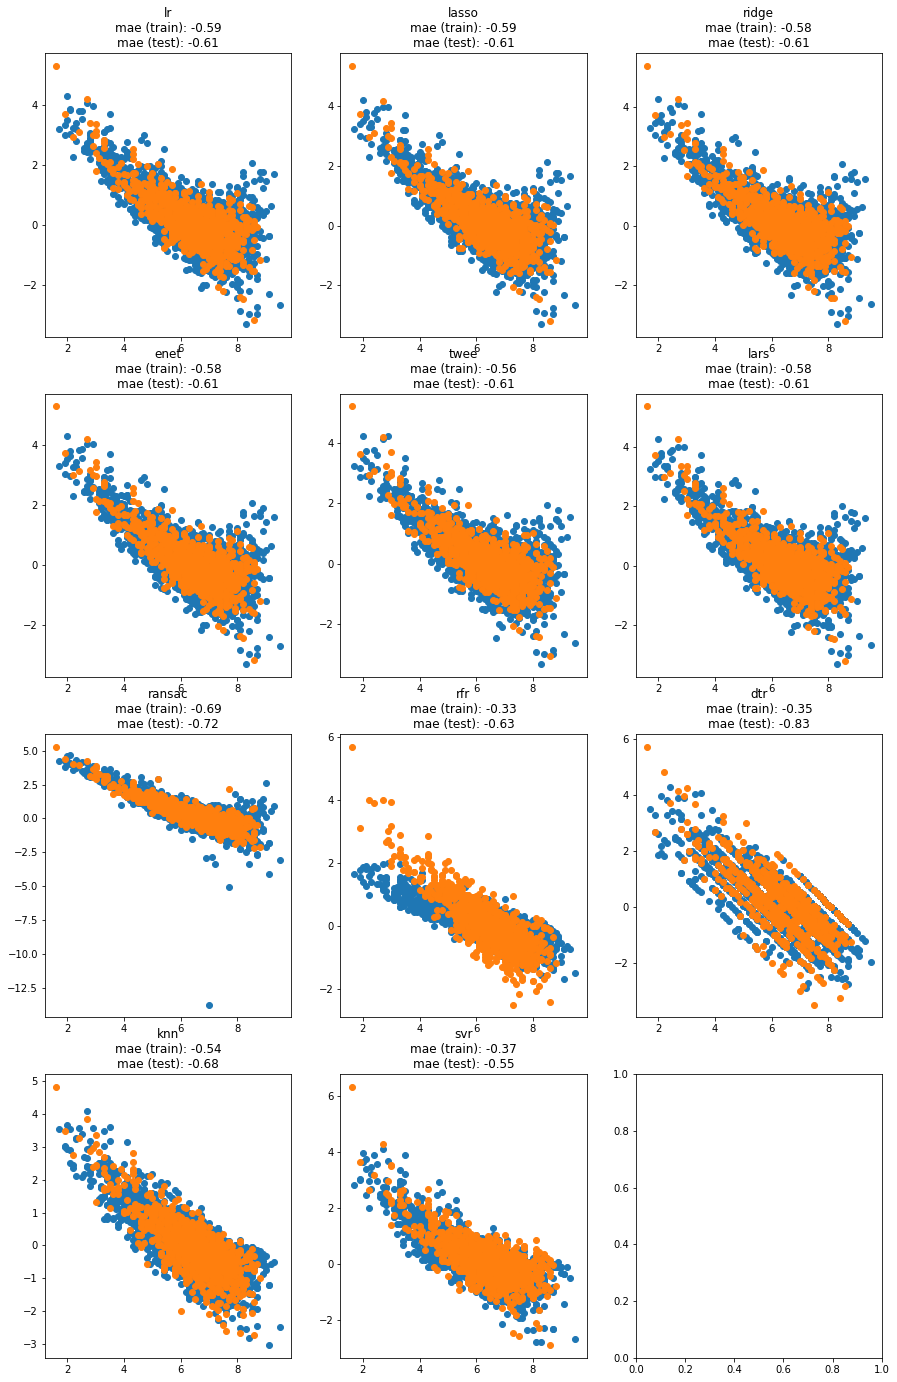

In [28]:
#@title Residual plot comparison
#@markdown Residual plots are shown for each model, with training data in blue and test data in orange.
compare_model_residuals(models,X_train,y_train,X_test,y_test)

#Conclusions


Comparing the residual plots we find that all models present higher bias in low ratings. In general, none of the models managed to deliver a good residual performance, as they all showed significant target-residual correlation, atributable to insufficient flexibility of the studied models for this dataset.
The significant number of features (14000+) asked for dimensionality reduction,  acomplished by a 100 component PCA (mainly for performance reasons). It remains open to try other dimensionality reduction approaches.

Models `lr`, `lasso`, `ridge`, `enet`, `twee` and `lars` perform very similarly with a feather-like pattern, presenting higher variance and lower bias on high ratings.

Tree based models tends to overfit easily. With some regularization, `dtr` gave a different balance, exchanging slightly higher variance on the full rating range to obtain lower bias on low ratings. The `rfr` model managed to keep lower bias while consistently giving away lower variance on the full rating range. These models, however did overfit easily, performing poorly in the test set

`ransac` performed very poorly with underlying linear model (not shown)

`knn` regressor performed similarly to linear models, with slighlty worse `mae` but wih a more consistent variance across the rating range.

The best performance was acomplished with `svr` model, not only by reaching the lowest `mae` value, but also by showing a sightly better residual plot, with consistent variance over the full range. 